In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import time

from IPython.display import clear_output
from numba import jit, cuda
from numba.typed import List
from plotly.subplots import make_subplots

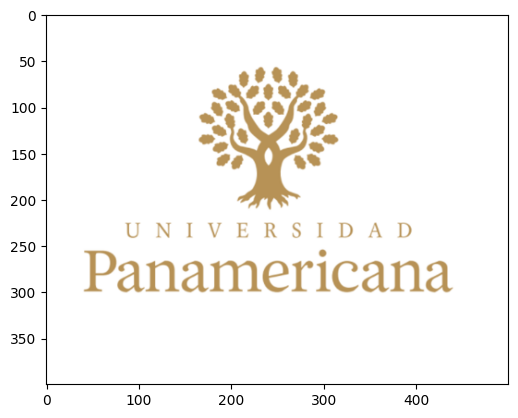

In [3]:
img = plt.imread('../images/UP.png')
plt.imshow(img)

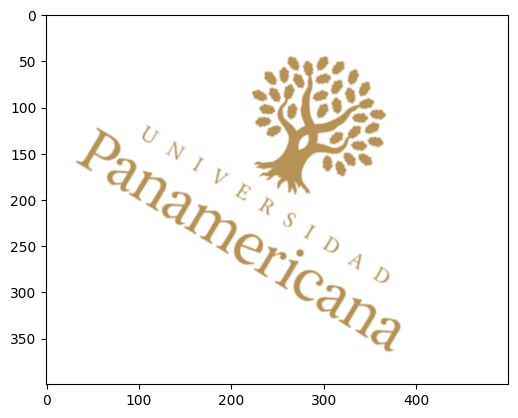

In [4]:
target = plt.imread('../images/UP_ROTATED.png')
plt.imshow(target)

In [7]:
@jit(target_backend='cuda') 
def to_matrix_function(X):
    assert len(X) == 5, "X must be a vector of 5 elements"
    tx, ty, th, sx, sy = X 
    scale = np.array([  [sx,  0],
                        [ 0, sy]], dtype=np.float64)
    th = np.radians(th)
    rotate = np.array([ [np.cos(th), -np.sin(th)],
                        [np.sin(th),  np.cos(th)]], dtype=np.float64)
    translate = np.array([tx, ty], dtype=np.float64)
    matrix = np.zeros((3,2), dtype=np.float64)
    matrix[:2, :] = np.matmul(scale, rotate)
    matrix[2, :] = translate
    return matrix.T

@jit(target_backend='cuda') 
def fitness(X, target):
    m = to_matrix_function(X)
    img_transformed = cv2.warpAffine(img, m, (img.shape[1], img.shape[0]))
    return np.sum(np.abs(img_transformed - target))

@jit(target_backend='cuda') 
def population_fitness(population, target):
    fitnesses = np.zeros(len(population))
    for i in range(len(population)):
        fitnesses[i] = fitness(population[i], target)
    return fitnesses

def evolution_strategy(target, sigma_rate, population_size, n_iter, verbose=False):
    population = np.random.normal(0, sigma_rate, (population_size, 5))
    sigma = np.ones((population_size, 5)) * sigma_rate
    fitnesses = population_fitness(population, target)
    best_individual = [population[np.argmin(fitnesses)]]
    best_fitnesses = [np.min(fitnesses)]
    for i in range(n_iter):
        new_population = np.zeros((population_size, 5))
        new_sigma = np.zeros((population_size, 5))
        for j in range(population_size):
            new_sigma[j] = sigma[j] * np.exp(0.2 * np.random.normal(0, 1, 5))
            new_population[j] = population[j] + new_sigma[j] * np.random.normal(0, 1, 5)
        new_fitnesses = population_fitness(new_population, target)
        population = np.concatenate((population, new_population))
        sigma = np.concatenate((sigma, new_sigma))
        fitnesses = np.concatenate((fitnesses, new_fitnesses))
        idx = np.argsort(fitnesses)[:population_size]
        population = population[idx]
        sigma = sigma[idx]
        fitnesses = fitnesses[idx]
        best_individual.append(population[0])
        best_fitnesses.append(np.min(fitnesses))
        if verbose:
            clear_output(wait=True)
            print(f"Iteration {i+1}/{n_iter} - Best fitness: {best_fitnesses[-1]}")
    return best_individual, best_fitnesses

In [6]:
start = time.time()
best_individual, best_fitnesses = evolution_strategy(target, 1.0, 100, 500, verbose=True)
end = time.time()
print(f"Time: {end - start}")

# Plot both target and result
m = to_matrix_function(best_individual)
img_transformed = cv2.warpAffine(img, m, (img.shape[1], img.shape[0]))
plt.subplot(1,2,1)
plt.imshow(target)
plt.subplot(1,2,2)
plt.imshow(img_transformed)

Iteration 500/500 - Best fitness: 19093.509765625
Time: 184.28758096694946


C:\Users\David Arcos\AppData\Local\Temp\ipykernel_22040\836505934.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "to_matrix_function" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(LiteralList((LiteralList((array(float64, 1d, C), Literal[int](0))), LiteralList((Literal[int](0), array(float64, 1d, C))))), dtype=class(float64))
 
There are 4 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba\core\overload_glue.py: Line 129.
      With argument(s): '(Poison<LiteralList((LiteralList((array(float64, 1d, C), Literal[int](0))), LiteralList((Literal[int](0), array(float64, 1d, C)))))>, dtype=class(float64))':
     Rejected as the implementation raised a specific error:
       TypingError: Poison type used in arguments; got Poison<LiteralList((LiteralList(

AssertionError: X must be a vector of 5 elements